#  Прогнозирование заказов такси

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split 
from statsmodels.tsa.seasonal import seasonal_decompose
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(data.head(10))
display(data.info())
data.describe()
data.sort_index(inplace=True)
data = data.resample('1H').sum() # выполним ресемплирование по одному часу
data = data.dropna() # удалим пропуски

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


None

In [2]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


## Анализ данных

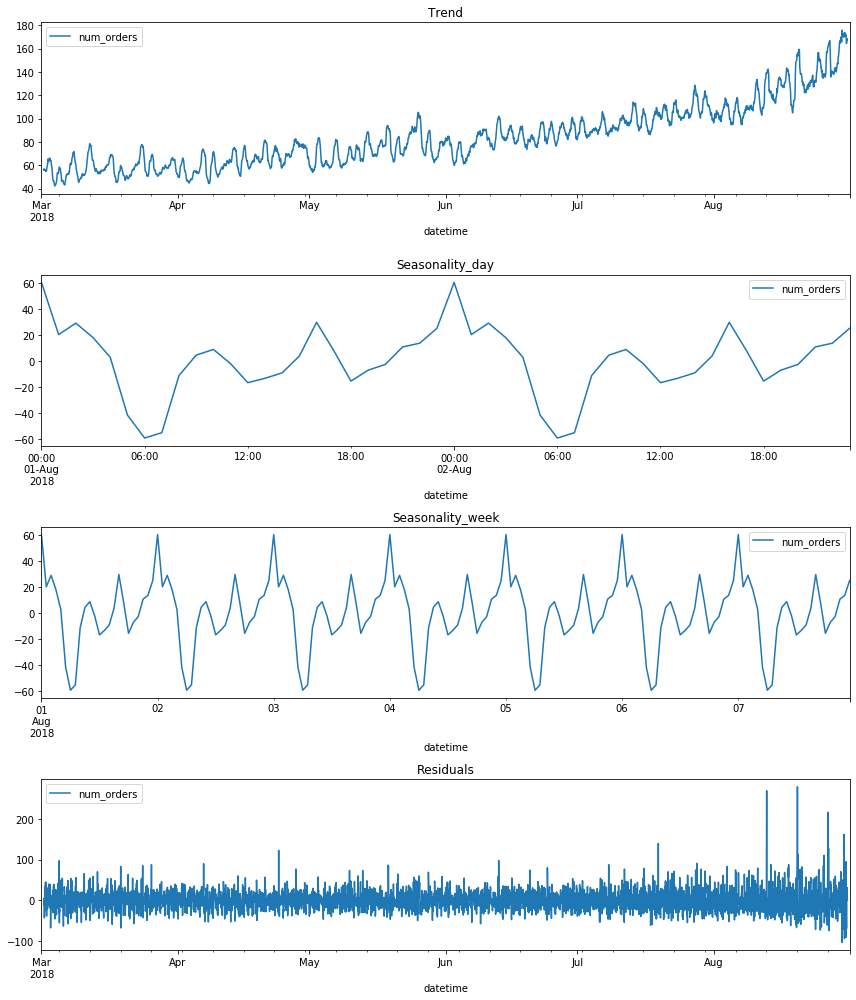

In [2]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(12, 14))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend') # плавное изменение среднего значения ряда без повторяющихся закономерностей
plt.subplot(412)
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca())
plt.title('Seasonality_day') # циклично повторяющиеся закономерности во временном ряду
plt.subplot(413)
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca())
plt.title('Seasonality_week')  
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals') # компонента, которая не объясняется трендом и сезонностью - шум
plt.tight_layout()

Тренды и сезонность зависят от масштаба данных. Нельзя увидеть закономерности, повторяющиеся каждое лето, если есть данные только за год. В нашем распоряжении оказались данные за 6 месяцев. 
* По графику "Тренд" мы можем заметить только то, что количество заказов такси увеличивается с начала марта по конец августа.
Тренд, как правило, связан со временем года. А сезонность с периодом меньше месяца. Поисследуем ее на разных промежутках.
* По графику "Сезонность за сутки" мы можем отметить пиковые активности. Минимальное число заказов приходится на 6 утра, максимальное на 12 ночи. Также высокое число заказов в вечернее время (4-5 часов вечера).
* По графику "Сезонность за неделю" мы видим, что картина числа заказов не изменяется в зависимости от того будни это или выходные. 
Остатки (т.е. шум) необъяснимы.

In [2]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() # метод скользящего окна

make_features(data, 5, 24)

In [3]:
print(data)

                     num_orders  dayofweek  hour  lag_1  lag_2  lag_3  lag_4  \
datetime                                                                       
2018-03-01 00:00:00         124          3     0    NaN    NaN    NaN    NaN   
2018-03-01 01:00:00          85          3     1  124.0    NaN    NaN    NaN   
2018-03-01 02:00:00          71          3     2   85.0  124.0    NaN    NaN   
2018-03-01 03:00:00          66          3     3   71.0   85.0  124.0    NaN   
2018-03-01 04:00:00          43          3     4   66.0   71.0   85.0  124.0   
...                         ...        ...   ...    ...    ...    ...    ...   
2018-08-31 19:00:00         136          4    19  207.0  217.0  197.0  116.0   
2018-08-31 20:00:00         154          4    20  136.0  207.0  217.0  197.0   
2018-08-31 21:00:00         159          4    21  154.0  136.0  207.0  217.0   
2018-08-31 22:00:00         223          4    22  159.0  154.0  136.0  207.0   
2018-08-31 23:00:00         205         

В данных наблюдается явная сезонность. Учитывая то, что данных мало, рассматривать глобальные циклы (год) нет смысла, поэтому год и месяц в расчет не берём. Число месяца тоже - циклы не привязаны к границам месяца, у них другой размер окна. Даже если число даст профит с точки зрения интерпретации результатов это плохо - у нас появится необъяснимый параметр.

## Обучение моделей

In [4]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

train_target = train['num_orders']
test_target = test['num_orders']

train_features = train.drop('num_orders', axis=1)
test_features = test.drop('num_orders', axis=1) 

research_result = pd.DataFrame(columns=['Model_name', 'RMSE_test'])

In [5]:
model_regression=LinearRegression()
model_regression.fit(train_features, train_target)
pred_train = model_regression.predict(train_features)
pred_test = model_regression.predict(test_features)
train_RMSE_regression = np.sqrt(mean_squared_error(train_target, pred_train)) 
print("RMSE обучающей выборки =", train_RMSE_regression)
test_RMSE_regression = np.sqrt(mean_squared_error(test_target, pred_test))
print("RMSE тестовой выборки =", test_RMSE_regression)
research_result.loc[0, 'Model_name']='LinearRegression'
research_result.loc[0, 'RMSE_test']=test_RMSE_regression

RMSE обучающей выборки = 30.66220309270589
RMSE тестовой выборки = 50.2890192085309


In [6]:
model_tree = DecisionTreeRegressor(max_depth=None, min_samples_leaf=3, random_state=12345)
model_tree.fit(train_features, train_target)
pred_train = model_tree.predict(train_features)
pred_test = model_tree.predict(test_features)
train_RMSE_tree = np.sqrt(mean_squared_error(train_target, pred_train)) 
print("RMSE обучающей выборки =", train_RMSE_tree)
test_RMSE_tree = np.sqrt(mean_squared_error(test_target, pred_test))
print("RMSE тестовой выборки =", test_RMSE_tree)
research_result.loc[1, 'Model_name']='DecisionTreeRegressor'
research_result.loc[1, 'RMSE_test']=test_RMSE_tree

RMSE обучающей выборки = 11.4336567347946
RMSE тестовой выборки = 52.31131307245599


In [7]:
model_forest = RandomForestRegressor(n_estimators=20, max_depth=15, random_state=12345)
model_forest.fit(train_features, train_target)
pred_train_forest = model_forest.predict(train_features)
pred_test_forest = model_forest.predict(test_features)
train_RMSE_forest = np.sqrt(mean_squared_error(train_target, pred_train_forest)) 
print("RMSE обучающей выборки =", train_RMSE_forest)
test_RMSE_forest = np.sqrt(mean_squared_error(test_target, pred_test_forest))
print("RMSE тестовой выборки =", test_RMSE_forest)
research_result.loc[2, 'Model_name']='RandomForestRegressor'
research_result.loc[2, 'RMSE_test']=test_RMSE_forest

RMSE обучающей выборки = 10.606925552723562
RMSE тестовой выборки = 45.67428736266184


In [8]:
model_LGBMR = LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=12, learning_rate=0.2, n_estimators=100, random_state=12345)
model_LGBMR.fit(train_features, train_target)
pred_train_LGBMR = model_LGBMR.predict(train_features)
pred_test_LGBMR = model_LGBMR.predict(test_features)
train_RMSE_LGBMR = np.sqrt(mean_squared_error(train_target, pred_train_LGBMR)) 
print("RMSE обучающей выборки =", train_RMSE_LGBMR)
test_RMSE_LGBMR = np.sqrt(mean_squared_error(test_target, pred_test_LGBMR))
print("RMSE тестовой выборки =", test_RMSE_LGBMR)
research_result.loc[3, 'Model_name']='LGBMRegressor'
research_result.loc[3, 'RMSE_test']=test_RMSE_LGBMR

RMSE обучающей выборки = 12.549093433307734
RMSE тестовой выборки = 45.60141438830923


In [9]:
model_catboost = CatBoostRegressor(loss_function='RMSE', n_estimators = 100, silent = True)
model_catboost.fit(train_features, train_target)
pred_train = model_catboost.predict(train_features)
pred_test = model_catboost.predict(test_features)
train_RMSE_catboost = np.sqrt(mean_squared_error(train_target, pred_train)) 
print("RMSE обучающей выборки =", train_RMSE_catboost)
test_RMSE_catboost = np.sqrt(mean_squared_error(test_target, pred_test))
print("RMSE тестовой выборки =", test_RMSE_catboost)
research_result.loc[4, 'Model_name']='CatBoostRegressor'
research_result.loc[4, 'RMSE_test']=test_RMSE_catboost

RMSE обучающей выборки = 24.00608712015589
RMSE тестовой выборки = 55.01690054002876


## Тестирование

In [10]:
print(research_result.sort_values('RMSE_test'))

              Model_name RMSE_test
3          LGBMRegressor   45.6014
2  RandomForestRegressor   45.6743
0       LinearRegression    50.289
1  DecisionTreeRegressor   52.3113
4      CatBoostRegressor   55.0169


* Самая высокая точность предсказания по RMSE на тестовой выборке у случайного леса и LGB-модели (1 место).
* 2 место по точности у линейной регресии.
* Дерево решений и Catboost-модель занимают 3 и 4 место в нашем рейтинге.

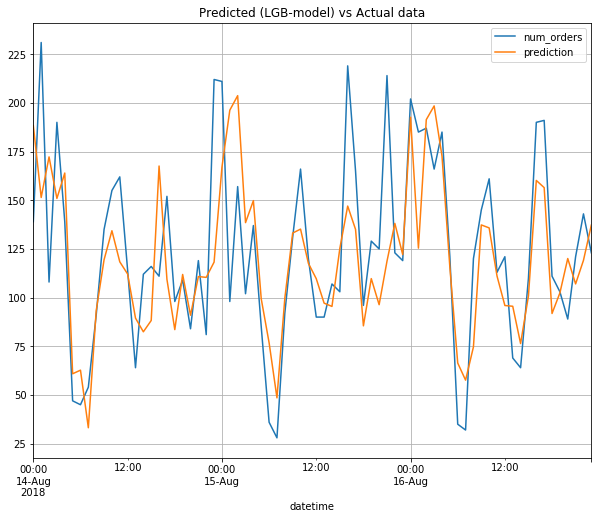

In [11]:
data_plot = test.copy()
data_plot['prediction'] = pred_test_LGBMR
predict_plot = data_plot[['num_orders', 'prediction']]['2018-08-14':'2018-08-16'].plot(kind='line', figsize=(10, 8), grid = True)
plt.title('Predicted (LGB-model) vs Actual data')
plt.show()

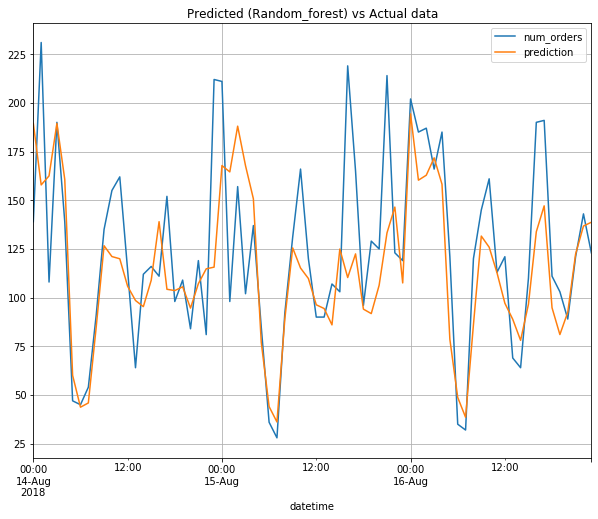

In [12]:
data_graph = test.copy()
data_graph['prediction'] = pred_test_forest
predict_plot = data_graph[['num_orders', 'prediction']]['2018-08-14':'2018-08-16'].plot(kind='line', figsize=(10, 8), grid = True)
plt.title('Predicted (Random_forest) vs Actual data')
plt.show()

Сравнительная динамика показывает, что обе наши модели Случайный лес и LGB-model хорошо предсказывают пиковые активности, причём минимумы предсказывает намного лучше, чем максимумы. Минимальное число заказов приходится на 6 утра как в актуальных данных, так и в предсказанных. Высокое число заказов в вечернее время (4-5 часов вечера) обе модели предсказывают хуже.
На мой взгляд верхние пики предсказаний LGB-model ближе к актуальным данным, чем верхние пики предсказаний Случайного леса. Нижние пики предсказаний Случайного леса ближе к актуальным данным, чем нижние пики предсказаний LGB-model.